# ML on ESDC using scikit-learn 
A DeepESDL example notebook

## Linear Regression for prediction of missing land surface temperature values from air temperature values
This notebook demonstrates how to implement Machine Learning on the Earth System Data Cube using the ML library scikit-learn. The workflow is self-contained and based on a generic use case to showcase data loading, sampling strategies, model training, model evaluation and visualisation.

Please, also refer to the DeepESDL documentation and visit the platform's website for further information!

ScaDS.AI, 2023

### Import necessary libraries
In case you experience an error due to a missing library xy, please install it via "pip install xy".

In [10]:
import math
import numpy as np
import pandas as pd
import mlflow
import xarray as xr
import dask.array as da
from xcube.core.store import new_data_store

from sklearn.linear_model import SGDRegressor
from sklearn.model_selection import train_test_split

from sklearn import metrics
import mltools as ml
from global_land_mask import globe
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap

### Load Data (Earth System Data Cube)
We load the ESDC (*.zarr) from the s3 data store (lazy load). The ESDC consists of three dimensions (longitude, latitude, time). Out of many available cube variables, which are dask arrays, we load two ("land_surface_temperature", "air_temperature_2m"). 

In [2]:
data_store = new_data_store("s3", root="esdl-esdc-v2.1.1", storage_options=dict(anon=True))
dataset = data_store.open_data('esdc-8d-0.083deg-184x270x270-2.1.1.zarr')
# use only lst and at
ds = dataset[['land_surface_temperature', 'air_temperature_2m']]
ds

<xarray.Dataset>
Dimensions:                   (time: 1840, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 1979-01-05 ... 2018-12-31
Data variables:
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(184, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

In [12]:
ds = xr.open_zarr("../data/lst_small.zarr")

### Add land mask variable 
Here we exclude redundant water surface values for our use case and only consider solid Earth data for our ML analysis. We extend the ESDC by a new variable "land_mask". The mask is a data array initialized for one time slice of the ESDC. 

In [13]:
lon_grid, lat_grid = np.meshgrid(ds.lon,ds.lat)
lm0 = da.from_array(globe.is_land(lat_grid, lon_grid))
lm0

dask.array<array, shape=(2160, 4320), dtype=bool, chunksize=(2160, 4320), chunktype=numpy.ndarray>

We now extend the mask to all time slices of the ESDC.

In [14]:
lm = da.stack([lm0 for i in range(ds.dims['time'])], axis = 0)
lm

dask.array<stack, shape=(10, 2160, 4320), dtype=bool, chunksize=(1, 2160, 4320), chunktype=numpy.ndarray>

We add the mask as variable to the ESDC. The cube now consists of three equally chunked variables ("land_surface_temperature", "air_temperature_2m", "land_mask"). 

In [15]:
xdsm = ds.assign(land_mask= (['time','lat','lon'],lm.rechunk(chunks=([v for k,v in ml.get_chunk_sizes(ds)]))))
xdsm

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

### Plot masked data for one time slice
To do that we convert the cube into a pandas dataframe.

In [27]:
df = xdsm.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  
lat        lon                                
 89.958333 -179.958333 2002-05-21      False  
           -179.875000 2002-05-21      False  
           -179.791667 2002-05-21      False  
           -179.708333 2002-05-21      False  
           -179.625000 2002-05-21      False  
...                           ...        ...  
-89.958333  179.625000 2002-05-21       True  
            179.708333 2002-05-21       True  
            179.791667 2002-05-21       True  
            179.875000 2002-05-21       True  
            179.958333 2002-05-21       True  

[9331200 rows x 4 columns]

Air Temperature

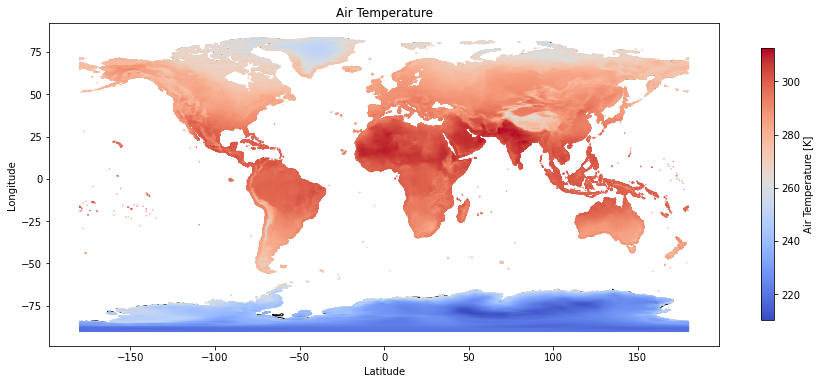

In [28]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'air_temperature_2m', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Air Temperature [K]'});

plt.title('Air Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('air_temp_masked.png')

Land Surface Temperature

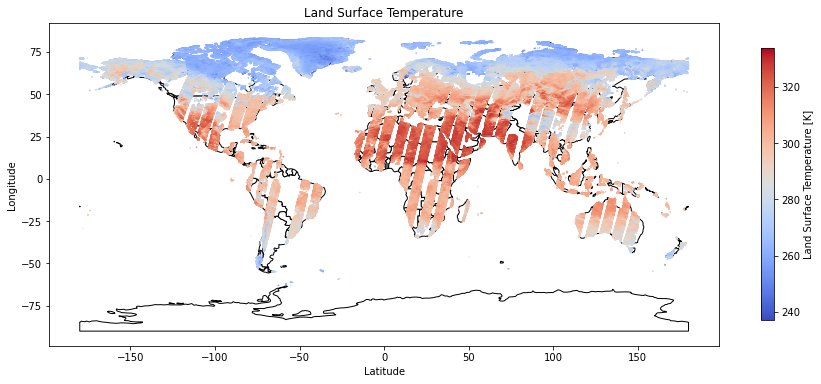

In [29]:
dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Land Surface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#plt.savefig('land_surface_temperature.png')

### Assign train/test split
Here you can choose between random sampling and block sampling. Based on the use case, the application of ML analyses on remotely sensed data is prone to autocorrelation, especially when the data is split randomly. Block sampling is one strategy to deal with autocorrelation.

In [19]:
# random sampling
#xds = xdsm.assign({"split": hf.rand})

# block sampling
xds = ml.assign_split(xdsm, block_size=[("time", 10), ("lat", 100), ("lon", 100)], split=0.7)
xds

<xarray.Dataset>
Dimensions:                   (time: 10, lat: 2160, lon: 4320)
Coordinates:
  * lat                       (lat) float64 89.96 89.88 89.79 ... -89.87 -89.96
  * lon                       (lon) float64 -180.0 -179.9 -179.8 ... 179.9 180.0
  * time                      (time) datetime64[ns] 2002-05-21 ... 2002-08-01
Data variables:
    air_temperature_2m        (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_surface_temperature  (time, lat, lon) float32 dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    land_mask                 (time, lat, lon) bool dask.array<chunksize=(10, 270, 270), meta=np.ndarray>
    split                     (time, lat, lon) float64 dask.array<chunksize=(10, 100, 100), meta=np.ndarray>
Attributes: (12/35)
    Metadata_conventions :     Unidata Dataset Discovery v1.0
    acknowledgment:            The ESDL team acknowledges all data providers! 
    chunking:                  1x2160x4320
    comment:                   none. 
    contributor_name:          Max Planck Institute for Biogeochemistry
    contributor_role:          ESDL Science Lead 
    ...                        ...
    summary:                   This data set contains a data cube of Earth Sy...
    time_coverage_duration:    P40Y
    time_coverage_end:         31.12.2018
    time_coverage_resolution:  P8D
    time_coverage_start:       05.01.1979
    title:                     Earth System Data Cube

Plot train/test assignment

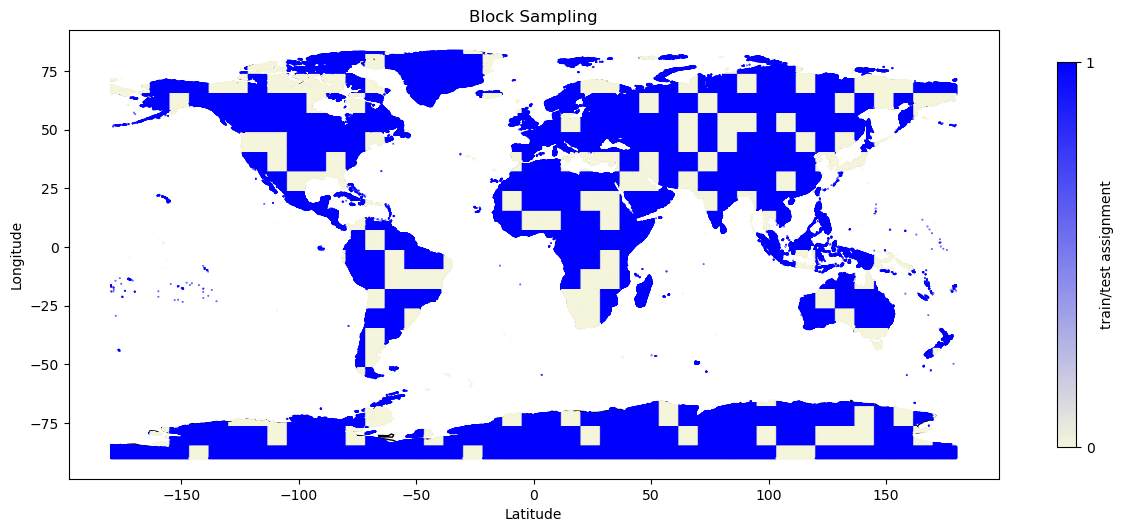

In [14]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()

dfdn = df[df['land_mask'] == True]
dfdn = dfdn.reset_index()

geometry = [Point(xy) for xy in zip(dfdn['lon'], dfdn['lat'])]
gdf = GeoDataFrame(dfdn, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
    column = 'split', cmap = LinearSegmentedColormap.from_list("", ["beige","blue"]), legend = True, legend_kwds={
        "shrink":.5, 'label': 'train/test assignment', 'ticks': [0,1]}) 

plt.title('Block Sampling')
plt.xlabel('Latitude')
plt.ylabel('Longitude')
#plt.savefig('train_test_assignment.png')

## Model set up

In [20]:
sgdreg = SGDRegressor()

Initialize MLFlow experiment

In [21]:
#tracking runs on local file system ./mlruns
#change location via mlflow.set_tracking_uri(path)
mlflow.sklearn.autolog()
experiment_name = "Sklearn Linear Regression of LST from AT with mlflow"
mlflow.set_experiment(experiment_name)

current_experiment=dict(mlflow.get_experiment_by_name(experiment_name))
experiment_id = current_experiment['experiment_id']

Get range (min, max) and statistics (mean, std) of data variables for normalization or standardization.

In [22]:
at_range = ml.getRange(ds, 'air_temperature_2m')
lst_range = ml.getRange(ds, 'land_surface_temperature')

at_stat = ml.getStatistics(ds, 'air_temperature_2m')
lst_stat = ml.getStatistics(ds, 'land_surface_temperature')

### Train model
We iterate through the chunks of the ESDC. The data will be preprocessed by flattening, choosing values, removing NaNs, normalization or standardization. Further, we will split the data into a training and testing fraction. We generate a train data loader and a test data loader and perform a linear regression. The train and test errors are returned during model training.

In [23]:
with mlflow.start_run(experiment_id=experiment_id) as run:
    for chunk in ml.iter_data_var_blocks(xds): 
        ### preprocessing
        cf = {x: chunk[x].ravel() for x in chunk.keys()}
        lm = cf['land_mask']
        cft = {x: cf[x][lm == True] for x in cf.keys()}
        lst = cft['land_surface_temperature']
        cfn = {x: cft[x][~np.isnan(lst)] for x in cft.keys()}
        #to_pred = {x: cft[x][np.isnan(lst)] for x in cft.keys()}
        if len(cfn['land_surface_temperature']) > 0:
            X = ml.normalize(cfn['air_temperature_2m'], *at_range)
            y = ml.normalize(cfn['land_surface_temperature'], *lst_range)
            ### assign train/test split
            #X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
            ### get train/test data 
            X_train = X[cfn['split']==True]
            X_test  = X[cfn['split']==False]
            y_train = y[cfn['split']==True]
            y_test  = y[cfn['split']==False]
            ### train model
            if len(X_train) > 0:
                sgdreg.fit(X_train.reshape(-1, 1), y_train)

                y_pred_train = sgdreg.predict(X_train.reshape(-1, 1))
                mse_train = metrics.mean_squared_error(y_train, y_pred_train)
                print(f"Training Error: {mse_train:>8f}")
                
                if len(X_test) > 0:
                    y_pred_test = sgdreg.predict(X_test.reshape(-1, 1))
                    mse_test  = metrics.mean_squared_error(y_test, y_pred_test)
            
                    print(f"Test Error: {mse_test:>8f}\n")

Training Error: 0.003400
Test Error: 0.003671

Training Error: 0.003315
Training Error: 0.003050
Test Error: 0.002425

Training Error: 0.001758
Training Error: 0.001578
Test Error: 0.001953

Training Error: 0.001438
Test Error: 0.001256

Training Error: 0.001253
Test Error: 0.001948

Training Error: 0.002000
Test Error: 0.002358

Training Error: 0.002946
Test Error: 0.003362

Training Error: 0.003422
Test Error: 0.004577

Training Error: 0.002852
Test Error: 0.001778

Training Error: 0.001917
Test Error: 0.001880

Training Error: 0.002180
Test Error: 0.001762

Training Error: 0.002707
Test Error: 0.002656

Training Error: 0.002847
Test Error: 0.003290

Training Error: 0.002171
Test Error: 0.003040

Training Error: 0.003086
Test Error: 0.004027

Training Error: 0.002818
Test Error: 0.004268

Training Error: 0.003288
Test Error: 0.004142

Training Error: 0.003742
Test Error: 0.003217

Training Error: 0.003177
Test Error: 0.004579

Training Error: 0.002799
Test Error: 0.003653

Training E

## Launch MLFlow UI

In [ ]:
!mlflow ui 
#visit https://mlflow-8a63c7.deep.earthsystemdatalab.net/
#this can be done in terminal simultaneously to calculating epochs

### Model Predictions

Get Air Temperature values for Lon/Lat with missing Land Surface Temperature values

In [24]:
df = xds.sel({'time' : '2002-05-21'}).to_dataframe()
df

air_temperature_2m  land_surface_temperature  \
lat        lon                                                         
 89.958333 -179.958333          266.297180                       NaN   
           -179.875000          266.297180                       NaN   
           -179.791667          266.297180                       NaN   
           -179.708333          266.297180                       NaN   
           -179.625000          266.297180                       NaN   
...                                    ...                       ...   
-89.958333  179.625000          219.817398                       NaN   
            179.708333          219.817398                       NaN   
            179.791667          219.817398                       NaN   
            179.875000          219.817398                       NaN   
            179.958333          219.817398                       NaN   

                             time  land_mask  split  
lat        lon                                       
 89.958333 -179.958333 2002-05-21      False    0.0  
           -179.875000 2002-05-21      False    0.0  
           -179.791667 2002-05-21      False    0.0  
           -179.708333 2002-05-21      False    0.0  
           -179.625000 2002-05-21      False    0.0  
...                           ...        ...    ...  
-89.958333  179.625000 2002-05-21       True    0.0  
            179.708333 2002-05-21       True    0.0  
            179.791667 2002-05-21       True    0.0  
            179.875000 2002-05-21       True    0.0  
            179.958333 2002-05-21       True    0.0  

[9331200 rows x 5 columns]

Predict missing Land Surface Temperature values from Air Temperature values

In [30]:
dfl = df[df['land_mask'] == True]
orig = dfl.dropna()
to_pred = dfl[np.isnan(dfl['land_surface_temperature'])]
output = to_pred.drop('land_surface_temperature', axis = 1)

X = ml.normalize(to_pred['air_temperature_2m'], *at_range)
X = X.values

lstp = sgdreg.predict(X.reshape(-1, 1))
output['land_surface_temperature'] = ml.undo_normalizing(lstp, *lst_range)
output

air_temperature_2m       time  land_mask  \
lat        lon                                                     
 83.208333 -73.958333           266.152954 2002-05-21       True   
 83.125000 -77.041667           265.867096 2002-05-21       True   
           -76.958333           265.832367 2002-05-21       True   
           -76.875000           265.832367 2002-05-21       True   
           -76.791667           265.832367 2002-05-21       True   
...                                    ...        ...        ...   
-89.958333  179.625000          219.817398 2002-05-21       True   
            179.708333          219.817398 2002-05-21       True   
            179.791667          219.817398 2002-05-21       True   
            179.875000          219.817398 2002-05-21       True   
            179.958333          219.817398 2002-05-21       True   

                        land_surface_temperature  
lat        lon                                    
 83.208333 -73.958333                 275.326355  
 83.125000 -77.041667                 275.261287  
           -76.958333                 275.253381  
           -76.875000                 275.253381  
           -76.791667                 275.253381  
...                                          ...  
-89.958333  179.625000                264.779195  
            179.708333                264.779195  
            179.791667                264.779195  
            179.875000                264.779195  
            179.958333                264.779195  

[1739067 rows x 4 columns]

### Plot Predictions

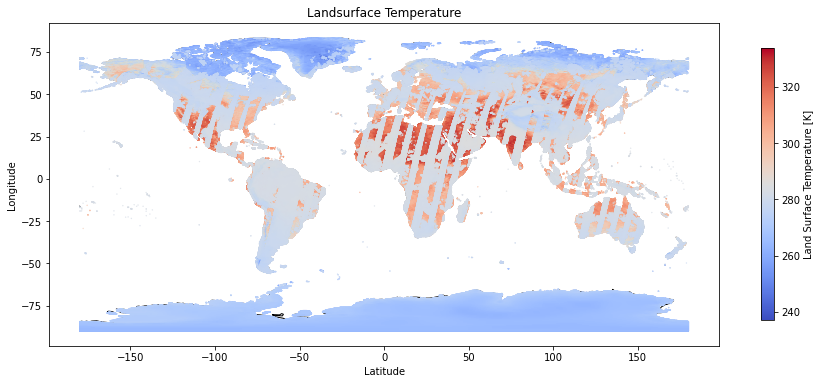

In [31]:
df = pd.concat([orig['land_surface_temperature'], output['land_surface_temperature']])
lst = df.reset_index()

geometry = [Point(xy) for xy in zip(lst['lon'], lst['lat'])]
gdf = GeoDataFrame(lst, geometry=geometry) 

#this is a simple map that goes with geopandas
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf.plot(figsize=(15, 10), markersize = 0.1,
    ax=world.plot(figsize=(15, 10), color='white', edgecolor='black'),
        column = 'land_surface_temperature', cmap = 'coolwarm', legend = True, legend_kwds={
        "shrink":.5, 'label': 'Land Surface Temperature [K]'});

plt.title('Landsurface Temperature');
plt.xlabel('Latitude');
plt.ylabel('Longitude');
#fname = 'xxx' +'.png'
#plt.savefig(fname)
plt.show()